In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.svm import SVC
from sklearn.metrics import classification_report, roc_auc_score, roc_curve, confusion_matrix
from sklearn.preprocessing import StandardScaler
from imblearn.over_sampling import SMOTE
import matplotlib.pyplot as plt



In [2]:
# Paso 1: Cargar los datos
# URL del dataset en GitHub
url = "https://raw.githubusercontent.com/kjra99/AMR_TFM/refs/heads/main/kidney_disease.csv"
# Cargar los datos directamente desde GitHub
data = pd.read_csv(url)

# Verificar la carga correcta mostrando las primeras filas
data.head()

,id,age,bp,sg,al,su,rbc,pc,pcc,ba,...,pcv,wc,rc,htn,dm,cad,appet,pe,ane,classification
0,0,48.0,80.0,1.020,1.0,0.0,NaN,normal,notpresent,notpresent,...,44,7800,5.2,yes,yes,no,good,no,no,ckd
1,1,7.0,50.0,1.020,4.0,0.0,NaN,normal,notpresent,notpresent,...,38,6000,NaN,no,no,no,good,no,no,ckd
2,2,62.0,80.0,1.010,2.0,3.0,normal,normal,notpresent,notpresent,...,31,7500,NaN,no,yes,no,poor,no,yes,ckd
3,3,48.0,70.0,1.005,4.0,0.0,normal,abnormal,present,notpresent,...,32,6700,3.9,yes,no,no,poor,yes,yes,ckd
4,4,51.0,80.0,1.010,2.0,0.0,normal,normal,notpresent,notpresent,...,35,7300,4.6,no,no,no,good,no,no,ckd


In [3]:
# Renombrar columnas para mayor claridad
data.rename(columns={
    'id': 'ID',
    'age': 'Edad',
    'bp': 'Presion_Arterial',
    'sg': 'Gravedad_Especifica',
    'al': 'Albumina',
    'su': 'Azucar',
    'rbc': 'Globulos_Rojos',
    'pc': 'Celulas_Epiteliales',
    'pcc': 'Celulas_Cumulos',
    'ba': 'Bacterias',
    'bgr': 'Glucosa_Sangre',
    'bu': 'Urea_Sangre',
    'sc': 'Creatinina_Sangre',
    'sod': 'Sodio',
    'pot': 'Potasio',
    'hemo': 'Hemoglobina',
    'pcv': 'Volumen_Celular',
    'wc': 'Globulos_Blancos',
    'rc': 'Recuento_Rojos',
    'htn': 'Hipertension',
    'dm': 'Diabetes',
    'cad': 'Cardiopatia',
    'appet': 'Apetito',
    'pe': 'Edema_Pedal',
    'ane': 'Anemia',
    'classification': 'Clasificacion'
}, inplace=True)




In [4]:
# Paso 2: Filtrar pacientes con ERC
data = data[data['Clasificacion'] == 'ckd']

# Paso 3: Preprocesamiento
# Eliminar filas con valores nulos en la columna 'Diabetes'
data = data.dropna(subset=['Anemia'])



In [5]:
# Selección de variables relevantes
variables = ['Edad', 'Presion_Arterial', 'Glucosa_Sangre', 'Urea_Sangre','Azucar', 'Sodio',
             'Creatinina_Sangre', 'Potasio', 'Hemoglobina', 'Albumina']


# Imputación de valores nulos
for col in variables:
    if data[col].isnull().sum() > 0:
        if data[col].dtype == 'object':
            data[col].fillna(data[col].mode()[0], inplace=True)
        else:
            data[col].fillna(data[col].mean(), inplace=True)

# Convertir columnas categóricas a numéricas
binary_columns = ['Hipertension', 'Diabetes', 'Cardiopatia', 'Edema_Pedal', 'Anemia']
for col in binary_columns:
    data[col] = data[col].map({'yes': 1, 'no': 0})

categorical_columns = {
    'Globulos_Rojos': {'normal': 0, 'abnormal': 1},
    'Celulas_Epiteliales': {'normal': 0, 'abnormal': 1},
    'Apetito': {'good': 1, 'poor': 0},
    'Celulas_Cumulos': {'notpresent': 0, 'present': 1},
    'Bacterias': {'notpresent': 0, 'present': 1}
}

for col, mapping in categorical_columns.items():
    data[col] = data[col].map(mapping)

<ipython-input-5-c46f95d1c2dd>:12: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  data[col].fillna(data[col].mean(), inplace=True)


In [6]:
# Paso 1: Rellenar o eliminar valores nulos en 'Anemia'
data['Anemia'] = data['Anemia'].fillna(data['Anemia'].mode()[0])  # Rellenar con la moda

# Verificar que no haya valores nulos en 'Anemia'
print("Valores únicos en 'Anemia' después de la limpieza:", data['Anemia'].unique())




Valores únicos en 'Anemia' después de la limpieza: [0 1]


In [7]:
data.describe()

,ID,Edad,Presion_Arterial,Gravedad_Especifica,Albumina,Azucar,Globulos_Rojos,Celulas_Epiteliales,Celulas_Cumulos,Bacterias,...,Creatinina_Sangre,Sodio,Potasio,Hemoglobina,Hipertension,Diabetes,Cardiopatia,Apetito,Edema_Pedal,Anemia
count,248.000000,248.000000,248.000000,207.000000,248.000000,248.000000,106.000000,193.000000,248.000000,248.000000,...,248.000000,248.000000,248.000000,248.000000,248.000000,242.000000,246.000000,248.000000,248.000000,248.000000
mean,124.427419,54.425000,79.705882,1.013937,1.721154,0.770732,0.443396,0.388601,0.165323,0.088710,...,4.430720,133.882530,4.883030,10.652217,0.584677,0.545455,0.138211,0.677419,0.306452,0.237903
std,72.079429,17.127132,14.932969,0.004630,1.259501,1.227592,0.499146,0.488700,0.372223,0.284899,...,6.805612,10.185319,3.542576,1.980642,0.493774,0.498962,0.345825,0.468409,0.461952,0.426661
min,0.000000,2.000000,50.000000,1.005000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.500000,4.500000,2.500000,3.100000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,62.750000,47.750000,70.000000,1.010000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,1.500000,133.882530,4.100000,9.800000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,124.500000,58.500000,80.000000,1.015000,1.721154,0.000000,0.000000,0.000000,0.000000,0.000000,...,2.450000,133.882530,4.883030,10.652217,1.000000,1.000000,0.000000,1.000000,0.000000,0.000000
75%,186.250000,65.000000,90.000000,1.015000,3.000000,0.770732,1.000000,1.000000,0.000000,0.000000,...,4.430720,137.000000,4.883030,11.800000,1.000000,1.000000,0.000000,1.000000,1.000000,0.000000
max,249.000000,90.000000,180.000000,1.025000,5.000000,5.000000,1.000000,1.000000,1.000000,1.000000,...,76.000000,163.000000,47.000000,16.100000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [8]:
data[variables].describe()

,Edad,Presion_Arterial,Glucosa_Sangre,Urea_Sangre,Azucar,Sodio,Creatinina_Sangre,Potasio,Hemoglobina,Albumina
count,248.000000,248.000000,248.000000,248.000000,248.000000,248.000000,248.000000,248.000000,248.000000,248.000000
mean,54.425000,79.705882,175.523810,72.656170,0.770732,133.882530,4.430720,4.883030,10.652217,1.721154
std,17.127132,14.932969,85.065928,57.156729,1.227592,10.185319,6.805612,3.542576,1.980642,1.259501
min,2.000000,50.000000,22.000000,1.500000,0.000000,4.500000,0.500000,2.500000,3.100000,0.000000
25%,47.750000,70.000000,110.750000,32.000000,0.000000,133.882530,1.500000,4.100000,9.800000,1.000000
50%,58.500000,80.000000,165.000000,55.000000,0.000000,133.882530,2.450000,4.883030,10.652217,1.721154
75%,65.000000,90.000000,210.750000,90.000000,0.770732,137.000000,4.430720,4.883030,11.800000,3.000000
max,90.000000,180.000000,490.000000,391.000000,5.000000,163.000000,76.000000,47.000000,16.100000,5.000000


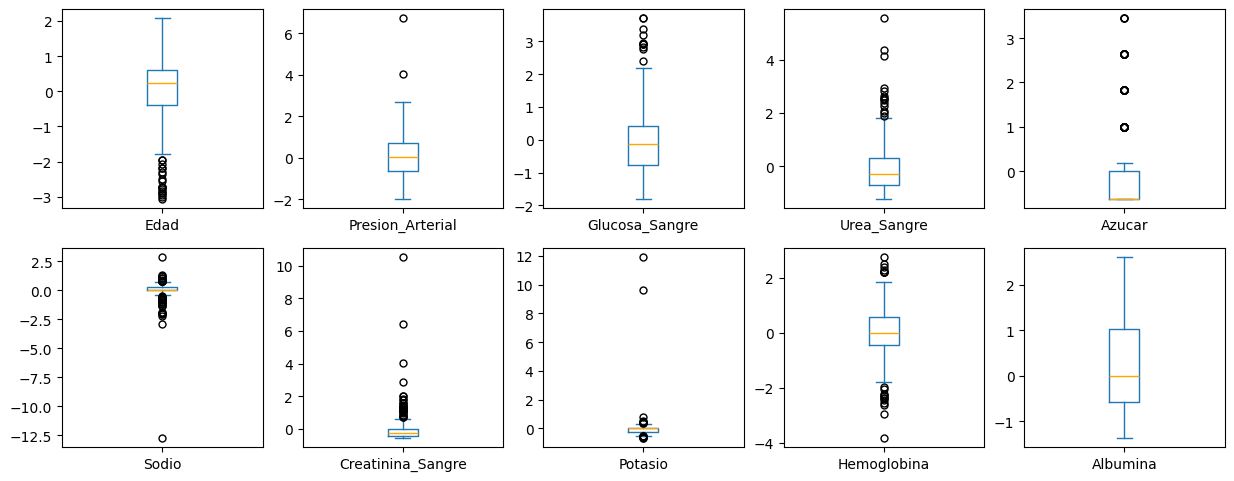

In [16]:
import matplotlib.pyplot as plt

# Supongamos que data es tu DataFrame

# Crear gráficos de caja para cada columna
data[variables].plot(kind='box', subplots=True, layout=(5, 5), figsize=(15, 15),boxprops=dict(color='#1f77b4'), medianprops=dict(color='orange'),flierprops=dict(marker='o', color='black', markersize=5))

# Mostrar el gráfico
plt.show()

In [10]:
# Normalización de datos
scaler = StandardScaler()
data[variables] = scaler.fit_transform(data[variables])

# División de datos en entrenamiento y prueba
X = data[variables]
y = data['Anemia']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# Balanceo de datos con SMOTE
smote = SMOTE(random_state=42)
X_train_balanced, y_train_balanced = smote.fit_resample(X_train, y_train)

In [11]:
X.describe()

,Edad,Presion_Arterial,Glucosa_Sangre,Urea_Sangre,Azucar,Sodio,Creatinina_Sangre,Potasio,Hemoglobina,Albumina
count,2.480000e+02,2.480000e+02,2.480000e+02,2.480000e+02,2.480000e+02,2.480000e+02,2.480000e+02,2.480000e+02,2.480000e+02,2.480000e+02
mean,1.683241e-16,1.647428e-16,7.520866e-17,-2.148819e-17,7.162729e-18,-2.256260e-16,-7.162729e-17,1.217664e-16,1.504173e-16,-2.542769e-16
std,1.002022e+00,1.002022e+00,1.002022e+00,1.002022e+00,1.002022e+00,1.002022e+00,1.002022e+00,1.002022e+00,1.002022e+00,1.002022e+00
min,-3.067123e+00,-1.993305e+00,-1.808412e+00,-1.247448e+00,-6.291101e-01,-1.272853e+01,-5.787384e-01,-6.740431e-01,-3.820726e+00,-1.369299e+00
25%,-3.905206e-01,-6.512777e-01,-7.629941e-01,-7.127487e-01,-6.291101e-01,0.000000e+00,-4.315037e-01,-2.214811e-01,-4.311432e-01,-5.737288e-01
50%,2.384077e-01,1.973569e-02,-1.239637e-01,-3.095327e-01,-6.291101e-01,0.000000e+00,-2.916308e-01,2.512224e-16,-8.986730e-16,-1.766522e-16
75%,6.186900e-01,6.907491e-01,4.149420e-01,3.040570e-01,0.000000e+00,3.066938e-01,0.000000e+00,2.512224e-16,5.806726e-01,1.017412e+00
max,2.081314e+00,6.729870e+00,3.704328e+00,5.580928e+00,3.452142e+00,2.864550e+00,1.053748e+01,1.191284e+01,2.756077e+00,2.608553e+00


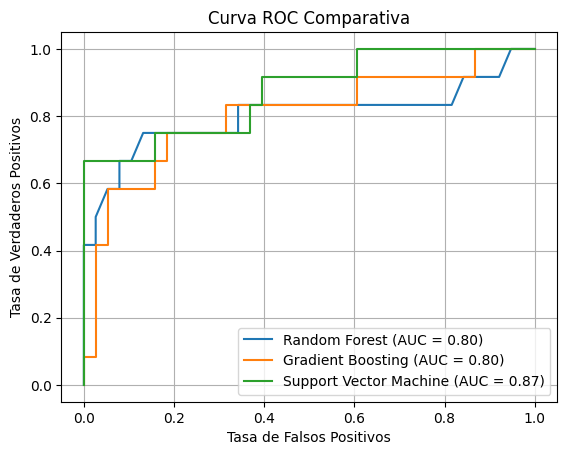

In [12]:

# Paso 4: Comparar tres modelos
models = {
    'Random Forest': RandomForestClassifier(random_state=42),
    'Gradient Boosting': GradientBoostingClassifier(random_state=42),
    'Support Vector Machine': SVC(probability=True, random_state=42)
}

results = {}
for model_name, model in models.items():
    model.fit(X_train_balanced, y_train_balanced)
    y_pred = model.predict(X_test)
    y_pred_prob = model.predict_proba(X_test)[:, 1]
    auc = roc_auc_score(y_test, y_pred_prob)
    report = classification_report(y_test, y_pred, output_dict=True)
    results[model_name] = {
        'AUC': auc,
        'Classification Report': report
    }

    # Curva ROC
    fpr, tpr, thresholds = roc_curve(y_test, y_pred_prob)
    plt.plot(fpr, tpr, label=f'{model_name} (AUC = {auc:.2f})')

plt.title('Curva ROC Comparativa')
plt.xlabel('Tasa de Falsos Positivos')
plt.ylabel('Tasa de Verdaderos Positivos')
plt.legend()
plt.grid()
plt.show()


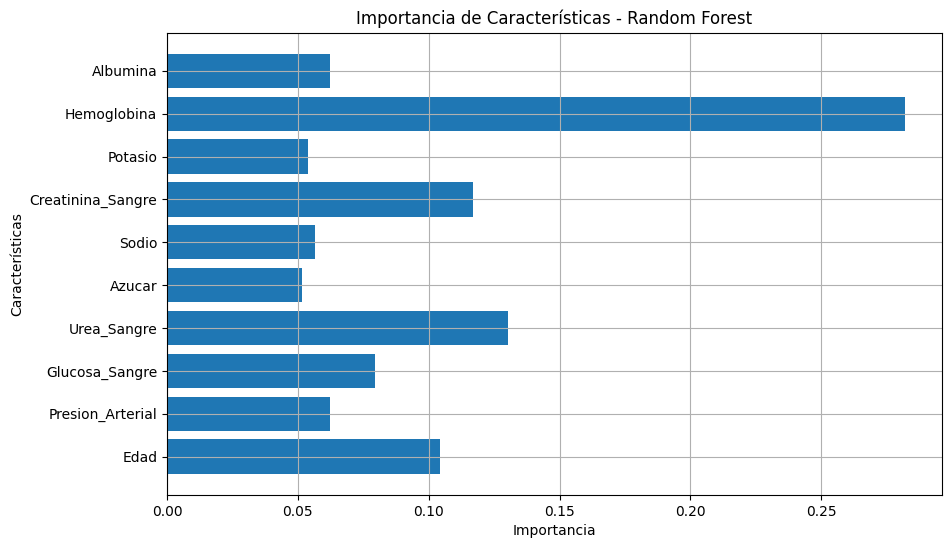

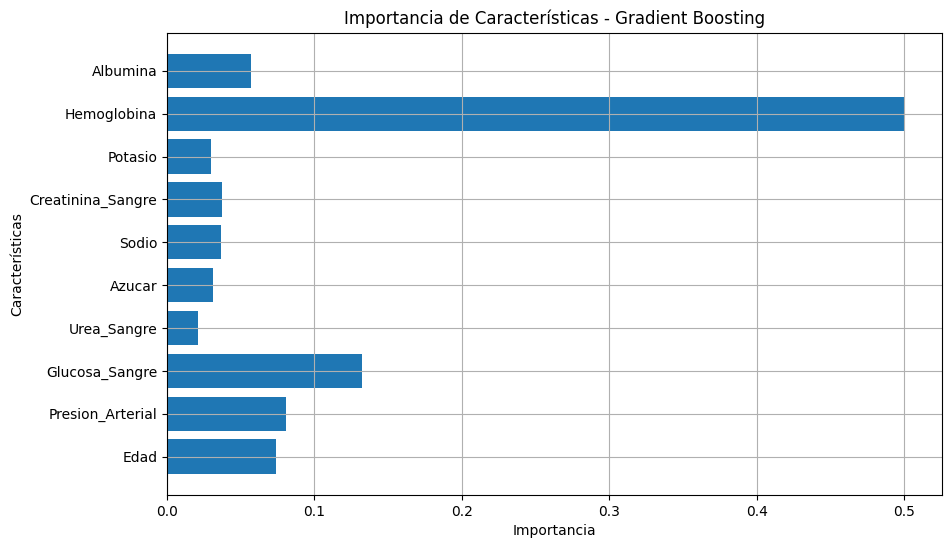

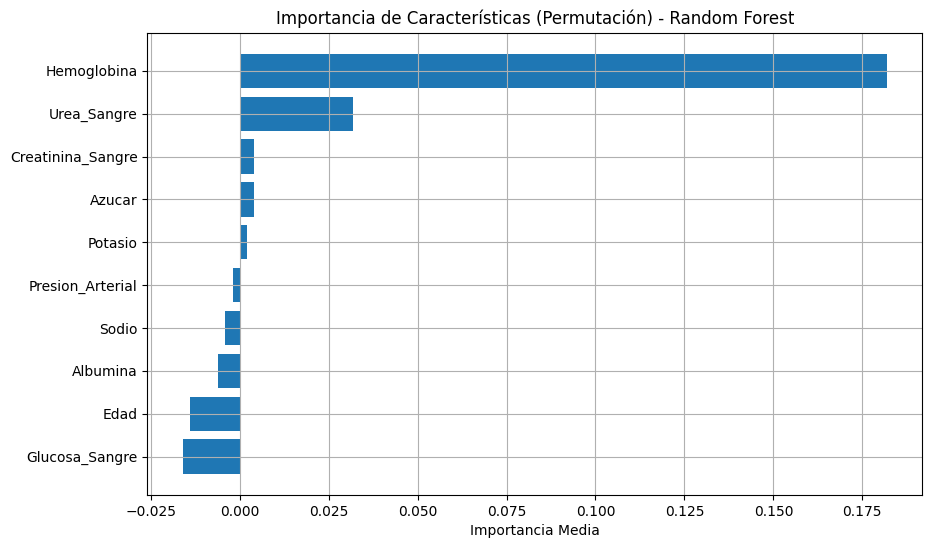

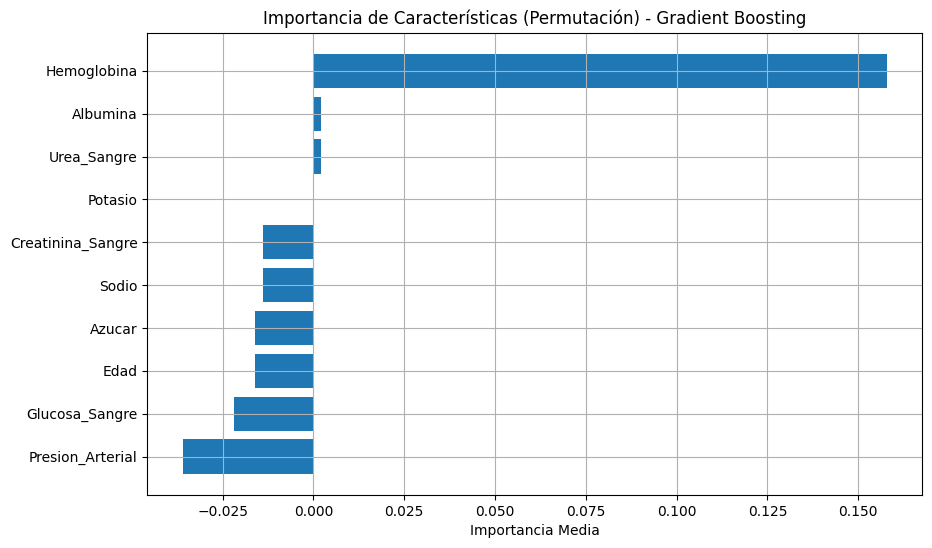

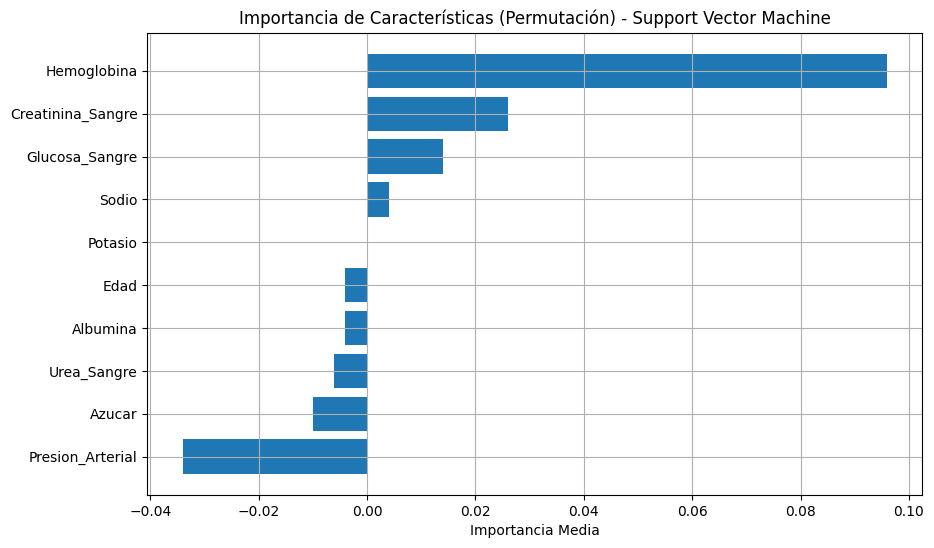


Resultados Comparativos:
                             AUC  F1-Score
Random Forest           0.802632  0.852658
Gradient Boosting       0.804825  0.800000
Support Vector Machine  0.872807  0.804990


In [13]:

# Paso 5: Visualización de importancia de características (solo para Random Forest y Gradient Boosting)
for model_name in ['Random Forest', 'Gradient Boosting']:
    model = models[model_name]
    if hasattr(model, 'feature_importances_'):
        plt.figure(figsize=(10, 6))
        plt.barh(variables, model.feature_importances_)
        plt.title(f'Importancia de Características - {model_name}')
        plt.xlabel('Importancia')
        plt.ylabel('Características')
        plt.grid()
        plt.show()

# Paso 5: Alternativa a SHAP con Permutación de Importancias
from sklearn.inspection import permutation_importance

for model_name, model in models.items():
    perm_importance = permutation_importance(model, X_test, y_test, n_repeats=10, random_state=42)
    sorted_idx = perm_importance.importances_mean.argsort()

    plt.figure(figsize=(10, 6))
    plt.barh(np.array(variables)[sorted_idx], perm_importance.importances_mean[sorted_idx])
    plt.title(f'Importancia de Características (Permutación) - {model_name}')
    plt.xlabel('Importancia Media')
    plt.grid()
    plt.show()

# Paso 6: Mostrar resultados en tabla
resultados_df = pd.DataFrame({
    model_name: [results[model_name]['AUC'], results[model_name]['Classification Report']['weighted avg']['f1-score']]
    for model_name in results
}, index=['AUC', 'F1-Score']).T

print("\nResultados Comparativos:")
print(resultados_df)

Ejemplos de predicción para desarrollo de Anemia en pacientes con ERC:


/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but GradientBoostingClassifier was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but SVC was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but GradientBoostingClassifier was fitted with feature names
  warnings.warn(
/usr/local/lib/python

{'Paciente': 248, 'Random Forest': {'Riesgo': 'Bajo', 'Probabilidad': '0.19'}, 'Gradient Boosting': {'Riesgo': 'Bajo', 'Probabilidad': '0.29'}, 'Support Vector Machine': {'Riesgo': 'Medio', 'Probabilidad': '0.57'}}
{'Paciente': 138, 'Random Forest': {'Riesgo': 'Bajo', 'Probabilidad': '0.15'}, 'Gradient Boosting': {'Riesgo': 'Bajo', 'Probabilidad': '0.01'}, 'Support Vector Machine': {'Riesgo': 'Bajo', 'Probabilidad': '0.07'}}
{'Paciente': 53, 'Random Forest': {'Riesgo': 'Bajo', 'Probabilidad': '0.07'}, 'Gradient Boosting': {'Riesgo': 'Bajo', 'Probabilidad': '0.01'}, 'Support Vector Machine': {'Riesgo': 'Bajo', 'Probabilidad': '0.03'}}
{'Paciente': 114, 'Random Forest': {'Riesgo': 'Bajo', 'Probabilidad': '0.16'}, 'Gradient Boosting': {'Riesgo': 'Bajo', 'Probabilidad': '0.09'}, 'Support Vector Machine': {'Riesgo': 'Bajo', 'Probabilidad': '0.07'}}
{'Paciente': 78, 'Random Forest': {'Riesgo': 'Bajo', 'Probabilidad': '0.18'}, 'Gradient Boosting': {'Riesgo': 'Bajo', 'Probabilidad': '0.08'}, '

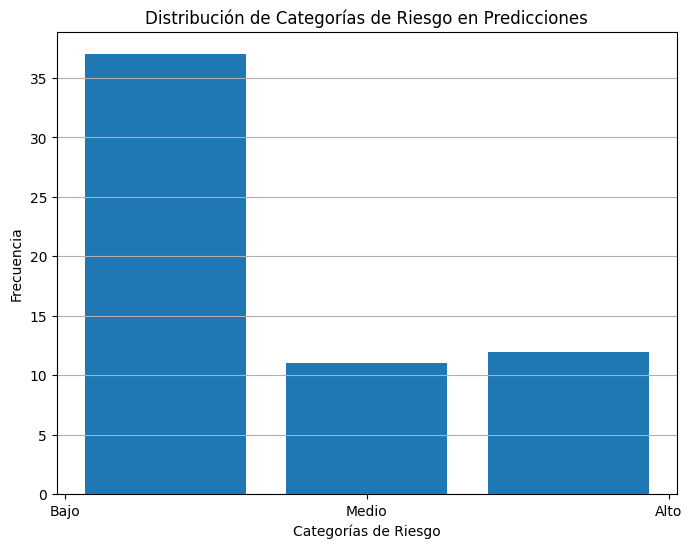

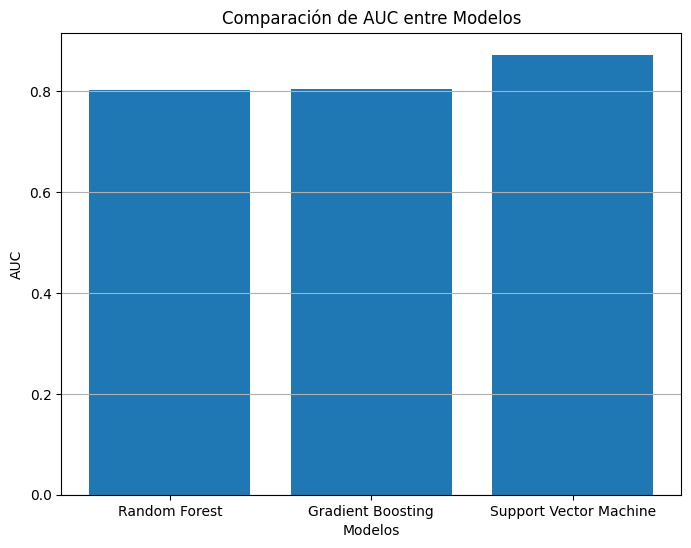

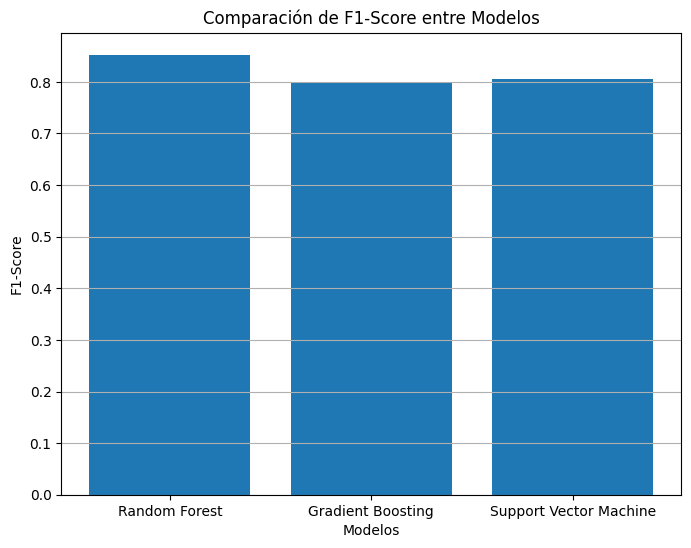

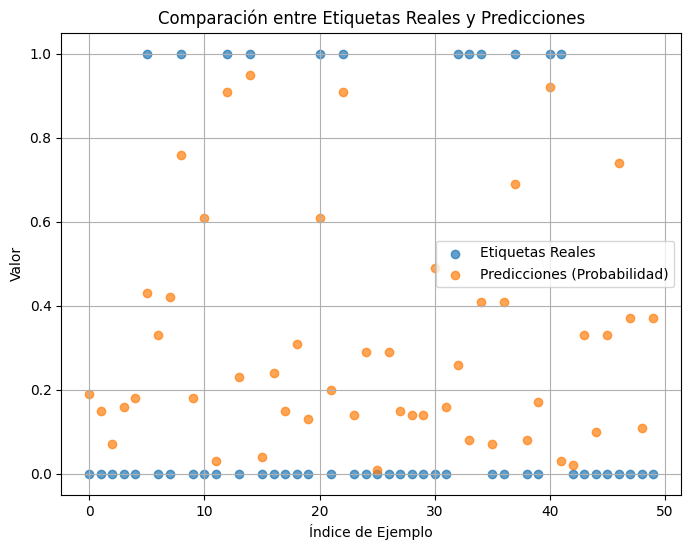

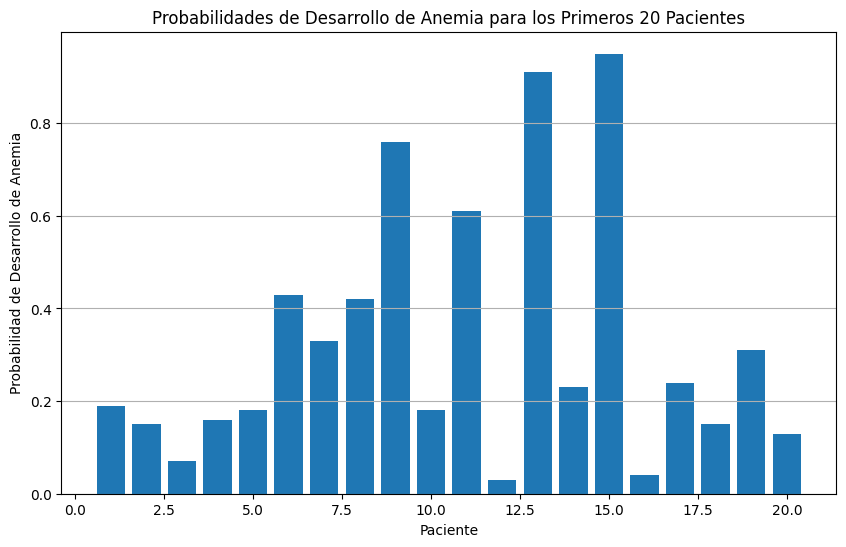

In [17]:
# EJEMPLOS DE PREDICCIÓN EN PACIENTES CON ERC
examples = X_test.iloc[:20]  # PRIMEROS 20 EJEMPLOS DE TEST
print("Ejemplos de predicción para desarrollo de Anemia en pacientes con ERC:")
example_results = []
for i, example in examples.iterrows():
    example_result = {"Paciente": i}
    for model_name, model in models.items():
        prob = model.predict_proba([example])[0][1]
        pred = "Alto" if prob > 0.66 else "Medio" if prob >= 0.33 else "Bajo"
        example_result[model_name] = {
            "Riesgo": pred,
            "Probabilidad": f"{prob:.2f}"
        }
    example_results.append(example_result)

for result in example_results:
    print(result)

# RESULTADOS COMPARATIVOS
resultados_df = pd.DataFrame({
    model_name: [results[model_name]['AUC'], results[model_name]['Classification Report']['weighted avg']['f1-score']]
    for model_name in results
}, index=['AUC', 'F1-Score']).T

print("\nResultados Comparativos para Desarrollo de Anemia en ERC:")
print(resultados_df)

# GRAFICOS ADICIONALES PARA RESALTAR RESULTADOS
# Distribución de las categorías de riesgo
riesgos = []
for example in example_results:
    for model_name in models.keys():
        riesgos.append(example[model_name]['Riesgo'])

plt.figure(figsize=(8, 6))
plt.hist(riesgos, bins=3, align='mid', rwidth=0.8, color='#1f77b4')
plt.title('Distribución de Categorías de Riesgo en Predicciones')
plt.xlabel('Categorías de Riesgo')
plt.ylabel('Frecuencia')
plt.grid(axis='y')
plt.show()

# Comparación de AUC entre modelos
auc_values = [results[model]['AUC'] for model in models.keys()]
plt.figure(figsize=(8, 6))
plt.bar(models.keys(), auc_values, color='#1f77b4')
plt.title('Comparación de AUC entre Modelos')
plt.xlabel('Modelos')
plt.ylabel('AUC')
plt.grid(axis='y')
plt.show()

# Comparación de F1-Score entre modelos
f1_scores = [results[model]['Classification Report']['weighted avg']['f1-score'] for model in models.keys()]
plt.figure(figsize=(8, 6))
plt.bar(models.keys(), f1_scores, color='#1f77b4')
plt.title('Comparación de F1-Score entre Modelos')
plt.xlabel('Modelos')
plt.ylabel('F1-Score')
plt.grid(axis='y')
plt.show()

# GRAFICO DE COMPARACIÓN ENTRE PREDICCIONES Y ETIQUETAS REALES
y_test_array = y_test.values
predicted_probs = models['Random Forest'].predict_proba(X_test)[:, 1]  # USANDO RANDOM FOREST COMO EJEMPLO
plt.figure(figsize=(8, 6))
plt.scatter(range(len(y_test_array)), y_test_array, label='Etiquetas Reales', alpha=0.7)
plt.scatter(range(len(predicted_probs)), predicted_probs, label='Predicciones (Probabilidad)', alpha=0.7)
plt.title('Comparación entre Etiquetas Reales y Predicciones')
plt.xlabel('Índice de Ejemplo')
plt.ylabel('Valor')
plt.legend()
plt.grid()
plt.show()

# GRAFICO PARA LAS 20 PERSONAS EJEMPLARES
pacientes = list(range(1, 21))
riesgos_random_forest = [float(example['Random Forest']['Probabilidad']) for example in example_results]
plt.figure(figsize=(10, 6))
plt.bar(pacientes, riesgos_random_forest, color='#1f77b4')
plt.title('Probabilidades de Desarrollo de Anemia para los Primeros 20 Pacientes')
plt.xlabel('Paciente')
plt.ylabel('Probabilidad de Desarrollo de Anemia')
plt.grid(axis='y')
plt.show()
